In [1]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/ralfbanisch/Documents/git/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model

Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)


In [2]:

methodName='T300/std_ref'#'frontier_points_corner'#'frontier_points_corner'#

############################

#######################
# simulation temperature
T=500.0
# target temperature
T_target=300.0

metric_choice = 'euclidean'#'euclidean'#'rmsd'#

computeReference=0

if methodName=='std_ref':
    addReference=0
else:
    addReference=1

  
dataName='Results/'
folderName='/Users/ralfbanisch/Documents/git/DFM/'
modelName='Dimer'

finalLength = None#30000
modnr = 1#1000

colective_variable = helpers.compute_radius
cv_name = 'Radius'

# results from this code will be saved here:
simulationFolder=folderName+dataName+'/TemporaryFigures_'+metric_choice+'/'+modelName+'/'+methodName

# load results from reference simulation already postprocessed

# reference at T300 saved at 
reference_folder='/Users/ralfbanisch/Documents/git/DFM/Results/Dimer/T300/'

In [3]:
mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)





temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')

# this will be used only to compare the target distributions
integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)
angstrom
System has 2 particle(s)
805.507877785 K
519.770710098 K


Loaded trajectory of length 1000000


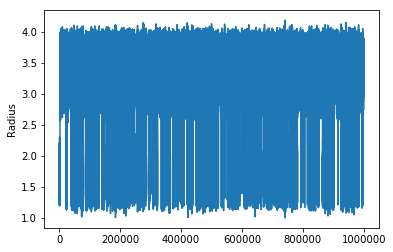

In [4]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = True

X_FT = helpers.loadData(folderName+dataName+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r)
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [5]:
def compute_free_energy(cv, weights=None, nrbins=100):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)

    return free_energy, bin_centers

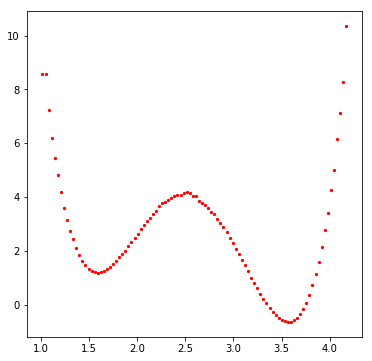

In [6]:
cv=colective_variable(X_FT)

free_energy_300_ref, bin_centers = compute_free_energy(cv, nrbins = 100)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bin_centers, free_energy_300_ref, s=5, c='r', marker='o')
plt.show()

Loaded trajectory of length 20000


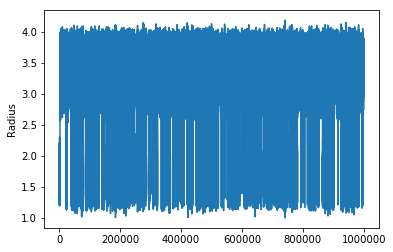

In [7]:
methodName='T500/std_500'#'frontier_points_corner'#'frontier_points_corner'#
modnr = 5
metric_choice = 'rmsd'

if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = True

X_FT = helpers.loadData(folderName+dataName+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
cv=colective_variable(X_FT)

plt.plot(range(len(r)), r)
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

Get the target density at sampled data points
... might take a while ...
Done
Done


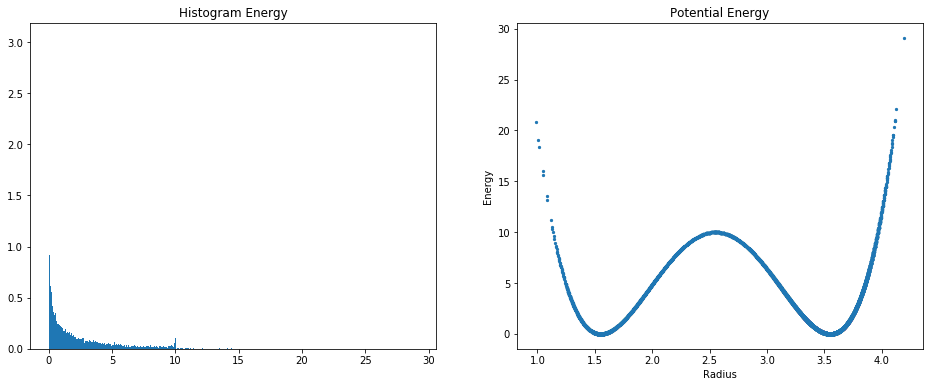

In [8]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [9]:
################ diffusion diffmaps
if metric_choice == 'euclidean':
    epsilon=0.1

    Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

    mydmap = dmpy.DiffusionMap(alpha = 1, n_evecs = 1, epsilon = epsilon,  k=1000, metric='euclidean')#, neighbor_params = {'n_jobs':-4})
    dmap = mydmap.fit_transform(Xresh, weights = qTargetDistribution_targetTemperature)

    P = mydmap.P
    evals = mydmap.evals
    evecs = mydmap.evecs

    [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
    phi = np.real(evecsT.ravel())

    q = mydmap.q

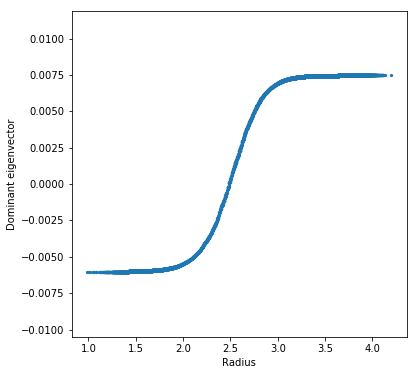

In [11]:
if metric_choice == 'rmsd':
    import scipy.sparse as sps

    traj = md.Trajectory(X_FT, mdl.testsystem.topology)

    indptr = [0]
    indices = []
    data = []
    k = 2000
    epsilon = 0.0001

    for i in range(traj.n_frames):
        # compute distances to frame i
        distances = md.rmsd(traj, traj, i)
        # this performs a partial sort so that idx[:k] are the indices of the k smallest elements
        idx = np.argpartition(distances, k)
        # retrieve corresponding k smallest distances
        distances = distances[idx[:k]]
        # append to data structure
        data.extend(np.exp(-1.0/epsilon*distances**2).tolist())
        indices.extend(idx[:k].tolist())
        indptr.append(len(indices))

    kernel_matrix = sps.csr_matrix((data, indices, indptr), dtype=float, shape=(traj.n_frames, traj.n_frames))

    # this is all stolen from pydiffmap
    weights_tmdmap = qTargetDistribution_targetTemperature

    alpha = 1.0
    q = np.array(kernel_matrix.sum(axis=1)).ravel()
    # Apply right normalization
    right_norm_vec = np.power(q, -alpha)
    if weights_tmdmap is not None:
        right_norm_vec *= np.sqrt(weights_tmdmap)

    m = right_norm_vec.shape[0]
    Dalpha = sps.spdiags(right_norm_vec, 0, m, m)
    kernel_matrix = kernel_matrix * Dalpha

    # Perform  row (or left) normalization
    row_sum = kernel_matrix.sum(axis=1).transpose()
    n = row_sum.shape[1]
    Dalpha = sps.spdiags(np.power(row_sum, -1), 0, n, n)
    P = Dalpha * kernel_matrix

    n_evecs = 2

    evals, evecs = spsl.eigs(P, k=(n_evecs+1), which='LM')
    ix = evals.argsort()[::-1][1:]
    evals = np.real(evals[ix])
    evecs = np.real(evecs[:, ix])
    dmap = np.dot(evecs, np.diag(evals))

    [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
    phi = np.real(evecsT.ravel())

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv, evecs[:,0], s=5)
    plt.xlabel('Radius')
    plt.ylabel('Dominant eigenvector')
    plt.show()

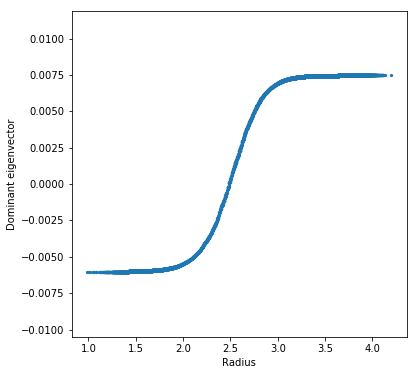

In [12]:

cv=colective_variable(X_FT)

fig = plt.figure(figsize=(6,6))
plt.scatter(cv, evecs[:,0], s=5)
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')
plt.show()

In [13]:
# estimated density by KDE
#q_est = q*phi#mydmap.q
q_est = q*phi
q_estNormalized = q_est/sum(q_est)

qTargetDistributionNormalized = qTargetDistribution/sum(qTargetDistribution)
print("Error on the density: "+repr(np.linalg.norm(q_estNormalized - qTargetDistributionNormalized,1)))

weight = qTargetDistribution_targetTemperature/q

qTargetDistribution_targetTemperature = qTargetDistribution_targetTemperature/sum(qTargetDistribution_targetTemperature)

Error on the density: 0.19133745504961103


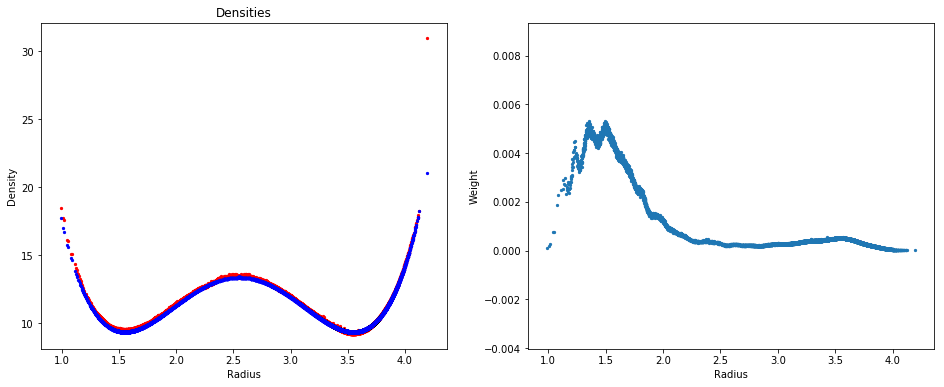

In [14]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(cv, -np.log(q_estNormalized), s=5, c='r')
ax.scatter(cv, -np.log(qTargetDistribution_targetTemperature), s=5, c='b')
ax.set_xlabel('Radius')
ax.set_ylabel('Density')


ax.set_title('Densities')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(cv, weight  ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Weight')
#ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/KDE_weight.png')


plt.show()

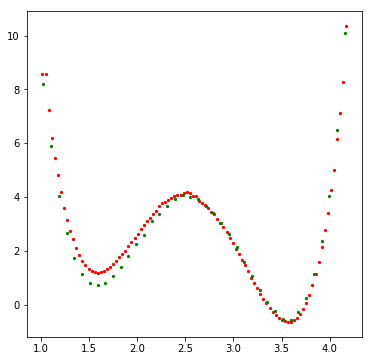

In [15]:
weight = qTargetDistribution_targetTemperature/q
cv=colective_variable(X_FT)

free_energy_unbiased, bin_centers_unb = compute_free_energy(cv, nrbins = 40, weights=weight*(cv**2))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bin_centers, free_energy_300_ref, s=5, c='r', marker='o')
ax.scatter(bin_centers_unb, free_energy_unbiased, s=5, c='g', marker='o')
plt.show()